# 1. Identifying Customer Segments

## a. Shoe Lovers
- The goal is to **identify shoe lovers**, in the context of an **email campaign** to **market a shoe**
  - We can define a **shoe lover** as someone who buys shoes, perhaps more frequently than other items
  - Our result will be a list of `user_id`s

### 1. Query
- For **Shoe Lovers**, features we can look at include:
  - How much does this person spend on shoes?
  - How much do they spend on shoes vs. other products?
- Because this is for an **email campaign**, we can try to identify other email-related features:
  - Rate of purchasing via email
  - Time between product launch and purchase


#### Assumptions
- The email campaign is marketing a shoe with conversions (purchases of said shoe) as its KPI
- Purchases made in the dataset were intended for the purchaser—they were not gifts
- The `launch date` of a product can be used as a proxy for the day the promotion for that product is launched
- Purchases made through the “email” order channel are completed shortly after the email is received


In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt

## we’ll first query at the order-level across all categories
## columns queried will coincide with features defined above

## dataframe of orders
df = pd.read_csv('orders.csv')

## fill in missing values, if any
df = df.fillna('n/a')

df.head()

,user_id,completed_at,order_channel_category,price,quantity,category,launch_date
0,1392297,2016-05-01 17:50:25,paid,55,1,Knit Dresses,2016-04-21 00:00:00
1,1674333,2017-01-04 10:54:37,paid,20,1,Knit Tops,2016-03-15 00:00:00
2,2144800,2017-11-10 11:24:56,email,100,1,Sweaters,2016-10-03 00:00:00
3,1733189,2017-04-13 15:14:23,direct,48,1,Knit Tops,2017-03-07 00:00:00
4,1031650,2017-06-19 05:03:04,direct,35,1,Knit Tops,2017-04-06 00:00:00


This data is at the order level, and we want to aggregate it to the `user_id` level. We’ll engineer the features mentioned above while doing so.

1. Spend on shoes
2. Total spend
3. Shoe vs total spend %
4. Item purchase count via email
5. Item purchase count total
6. Email vs total item purchase count %
7. Average time between product launch and purchase

In [2]:
## Create feature #7 (order complete date - launch date) first, before aggregation
from datetime import datetime

def days_between_dates(d1,d2):
  time_format = '%Y-%m-%d %H:%M:%S'
  dd1 = datetime.strptime(d1,time_format)
  dd2 = datetime.strptime(d2,time_format)
  days = (dd2-dd1).days
  if days < 0: 
    days = 0
  return days

df['launch_to_purchase_days'] = df.apply(lambda row: days_between_dates(row['launch_date'],row['completed_at']),axis=1)

#### Group the dataframe and aggregate the continuous variables
There will be some gymnastics required to get certain features, namely “spend on shoes” and “item purchase count via email”

In [3]:
## We need a new column if we want to differentiate between shoe spend and total spend
def spend_on_interest(interest,product_category,spend):
  ## is this purchase on an item of interest? (in this case, shoes?)
  if product_category == interest:
    return spend
  else:
    return 0
    
interest = 'Footwear'
df['spend_on_interest'] = df.apply(lambda row: spend_on_interest(interest,row['category'],row['price']), axis=1)

## We’ll do the same for order channels

def is_channel_purchase(channel,order_channel):
  ## was this purchase made through the desired channel? (in this case, email?)
  if order_channel == channel:
    return 1
  else:
    return 0
    
channel = 'email'
df['channel_purchase'] = df.apply(lambda row: is_channel_purchase(channel,row['order_channel_category']), axis=1)

We don’t need the columns that we used to create new features anymore

In [4]:
cols_to_drop = ['completed_at','order_channel_category','category','launch_date']
df = df.drop(cols_to_drop,axis=1)

Now we’ll aggregate our features to the `user_id` level, and sum the columns

In [5]:
aggregation = {
    'price': 'sum'
    ,'quantity': 'sum'
    ,'launch_to_purchase_days': 'mean'
    ,'spend_on_interest': 'sum'
    ,'channel_purchase': 'sum'
}

users = df.groupby('user_id').agg(aggregation)

## rename columns to be clearer
renames = {
  'launch_to_purchase_days':'average_days_to_buy'
  ,'spend_on_interest':'spend_on_{0}'.format(interest)
  ,'price':'total_spend'
  ,'channel_purchase':'purchases_from_{0}'.format(channel)
  ,'quantity':'total_purchases'
}

users = users.rename(columns=renames)
users = users.reset_index()
users.head()

,user_id,average_days_to_buy,spend_on_Footwear,total_spend,purchases_from_email,total_purchases
0,2826,66.500000,0,251,0,4
1,3275,43.000000,0,68,0,1
2,5782,361.500000,0,198,0,2
3,6161,139.833333,0,499,1,6
4,8746,327.666667,126,447,0,6


Now we need to get the rates of **shoe:total purchases**, and **email:all channels orders**

In [6]:
interest_spend_col = 'spend_on_{0}'.format(interest)
users['shoe_vs_total_spend'] = users.apply(lambda row: row[interest_spend_col]/row['total_spend'],axis=1)

interest_channel_col = 'purchases_from_{0}'.format(channel)
users['email_vs_total_purchases'] = users.apply(lambda row: row[interest_channel_col]/row['total_purchases'],axis=1)

users.head()

,user_id,average_days_to_buy,spend_on_Footwear,total_spend,purchases_from_email,total_purchases,shoe_vs_total_spend,email_vs_total_purchases
0,2826,66.500000,0,251,0,4,0.000000,0.000000
1,3275,43.000000,0,68,0,1,0.000000,0.000000
2,5782,361.500000,0,198,0,2,0.000000,0.000000
3,6161,139.833333,0,499,1,6,0.000000,0.166667
4,8746,327.666667,126,447,0,6,0.281879,0.000000


### 3. Classification
We have several features we can use to rank users based on their love of shoes. However, the current list is still all 12,520 users. We can immediately remove users who have never bought shoes from Everlane.

In [7]:
shoe_buyers = users[users['spend_on_Footwear'] > 0]

Now we have 2,521 shoe *buyers* out of 12,520 users. But how many of them are shoe *lovers*?

They could *all* be shoe lovers. If the campaign budget were large enough, it could be worth targeting all of them. 

#### What makes a shoe buyer a shoe *lover*?
We can find a threshold for each metric that separates the “buyers” from the “lovers.”

For simplicity’s sake, we’ll consider a “lover” to be anything more than your **average buyer**.

Your **average shoe buyer** spends the **average amount of money on shoes**, so your **shoe lover** spends above that average. This could be done with any/a combination of the features we’ve created, we’ll just do it on `spend_on_Footwear` for now.

In [8]:
## a shoe lover is anyone who spends above average on shoes
average_shoe_spend = shoe_buyers['spend_on_Footwear'].mean()
shoe_lovers = shoe_buyers[shoe_buyers['spend_on_Footwear'] >= average_shoe_spend]

This method yields us 764 users who are certified **shoe lovers**. This is around 6% of the total users.

As promised, we wanted a list of the user id’s

In [9]:
shoe_lover_ids = shoe_lovers['user_id']

 Some further exploration options (provided the data):
  1. What ratings did they give their purchased shoe? 
    - If they liked it, they may be inclined to buy more shoes from Everlane
  2. Do these people often buy things with deals (name your price, etc)? 
    - If so, perhaps only target them if these new shoes are eligible for these deals
  3. How does time since last purchase affect sales?
    - Explore relationship between this value and conversion
  4. What is the price-point that these customers buy at?
    - If some are more inclined to buy expensive items (split item costs into buckets), perhaps they are best targeted based on the price of the new shoe
  5. In a more comprehensive analysis, we could weigh the importance of each feature with some classifier (e.g. random forest), and assign a score to each user. Then, we could take a certain percentile of users from there as shoe _lovers_.


## b. All sorts of lovers
This is fairly simple, given the code written for **Question 1a**. 

We can actually just recycle all the code past the Query step (cells 1 and 2). 

*Note: We will define “lovers” the same way we did earlier—a lover is anyone who spends more on that category than the average Everlane customer does. Becuase of this, we can skip many of the previous steps that created columns that were not used for this particular definition of “lover”*

In [10]:
## helper function (rewritten here for reference)
def spend_on_interest(interest,product_category,spend):
  ## is this purchase on an item of interest? (in this case, shoes?)
  if product_category == interest:
    return spend
  else:
    return 0
    
## the actual function that gets us the lovers
def get_lovers(df,categories):
  ## returns a dictionary of lists
  lovers_by_category = {}
  
  ## 1. Engineer features
  df = df.fillna('n/a')
  for interest in categories:
    colname = 'spend_on_{0}'.format(interest)
    df[colname] = df.apply(lambda row: spend_on_interest(interest,row['category'],row['price']), axis=1)
    
  ## 2. Remove unnecessary columns
  cols_to_drop = ['completed_at','order_channel_category','category','launch_date']
  df = df.drop(cols_to_drop,axis=1)
  
  ## 3. Group the orders by user_id, aggregating the columns 
  users = df.groupby('user_id').sum()

  ## 4. rename columns to be clearer
  renames = {
    'price':'total_spend'
    ,'quantity':'total_purchases'
  }
  users = users.rename(columns=renames)
  users = users.reset_index()

  ## 5. Isolate “lovers” out of “buyers” for each category
  for interest in categories:
    colname = 'spend_on_{0}'.format(interest)
    buyers = users[users[colname] > 0]
    average_interest_spend = buyers[colname].mean()
    lovers = users[users[colname] >= average_interest_spend]
    ## 6. Add this list of lovers to the results dictionary
    lovers_by_category[interest] = lovers['user_id']

  return lovers_by_category

### Code to generate three lists of user_ids: Footwear, Sweater, and Knit Top lovers

In [11]:
df = pd.read_csv('orders.csv')
three_categories = ['Footwear','Sweaters','Knit Tops']
three_categories_lovers = get_lovers(df,three_categories)
for category,lovers in three_categories_lovers.items():
  print '{0} lovers for category: {1}'.format(len(lovers),category)
  print list(lovers)[0:5]
  print ''

1518 lovers for category: Knit Tops
[21694, 35024, 38811, 42064, 56060]

1178 lovers for category: Sweaters
[6161, 83528, 146356, 156071, 199111]

764 lovers for category: Footwear
[161584, 204727, 268792, 292843, 330687]



### Code to generate list of lovers for every category

In [12]:
## this is obviously very similar to the previous cell
df = pd.read_csv('orders.csv')
all_categories = df['category'].unique() ## a bit of a misnomer—this isn’t all the categories, 
                                         ## but all the categories that people have bought from.
                                         
all_categories_lovers = get_lovers(df,all_categories)
for category,lovers in all_categories_lovers.items():
  print '{0} lovers for category: {1}'.format(len(lovers),category)
  print list(lovers)[0:5]
  print ''

534 lovers for category: Bags
[132461, 158001, 174788, 180887, 203806]

526 lovers for category: Outerwear
[87397, 160357, 161584, 163554, 193104]

1518 lovers for category: Knit Tops
[21694, 35024, 38811, 42064, 56060]

324 lovers for category: Denim
[116655, 124570, 161584, 182302, 265031]

298 lovers for category: Woven Dresses
[10386, 87536, 238140, 294780, 381492]

127 lovers for category: Shirting
[291539, 350353, 490845, 526994, 541508]

1 lovers for category: Other
[2494158]

764 lovers for category: Footwear
[161584, 204727, 268792, 292843, 330687]

983 lovers for category: Bottoms
[2826, 55113, 56060, 84352, 84970]

715 lovers for category: Woven Tops
[93520, 123263, 171334, 238440, 244347]

157 lovers for category: Seasonal Accessories
[199111, 229479, 254176, 257259, 349642]

1178 lovers for category: Sweaters
[6161, 83528, 146356, 156071, 199111]

306 lovers for category: Knit Dresses
[40939, 291539, 350353, 462097, 524689]

172 lovers for category: SLGs
[130920, 137653, 2

## c. Shoe Lovers vs. Knit Top Lovers
With the list of user IDs for both groups, we can analyze trends in certain demographic variables that we have available (gender, location, discovery info)

We can engineer more variables from the other tables, but we’ll just look at the ones in the `recruiting.users` table for now.

### 1. Start off by getting a dataframe for each set of lovers

In [13]:
### 1. Get lists of lovers (user_ids), using the handy function from Question 1b.
df = pd.read_csv('orders.csv')

categories = ['Footwear','Knit Tops']
lovers = get_lovers(df,categories)
shoe_lovers = lovers['Footwear']
knit_top_lovers = lovers['Knit Tops']

### 2. We want to make each list into a dataframe, and join it with the users table
## Run a query (users) for all our users
users = pd.read_csv('users.csv')
users = users.fillna('n/a')

## our two resulting dataframes
shoe_lovers_df = pd.DataFrame({'user_id': shoe_lovers}).merge(users,on='user_id',how='left')
kt_lovers_df = pd.DataFrame({'user_id': knit_top_lovers}).merge(users,on='user_id',how='left')

### 2. Compare values between the two 
We’ll do some simple comparisons
  - Compare value counts for categorical features
  - Compare quartiles for continuous features
  

In [14]:
## get columns into a list
columns = list(shoe_lovers_df.columns)

### Examine categorical variables first
We’ll look at the ratios of values between the two groups of lovers, to see if any values are over/under-represented.
This would work for any categorical variables, but for now, we’ll look at the two most immediately available
1. Gender
2. Location

In [15]:
## identify categorical columns 
categorical_columns = [col for col in columns if shoe_lovers_df[col].dtype == 'object']

## create an empty dataframe
categoricals = pd.DataFrame()

## use value_counts() to get percentage representations of values within group
## then add this to the empty dataframe created above
for col in categorical_columns:
  vc1 = shoe_lovers_df[col].value_counts(normalize=True)
  vc2 = kt_lovers_df[col].value_counts(normalize=True)
  categoricals = pd.concat([pd.DataFrame({'Shoe Lovers':vc1,'Knit Top Lovers':vc2,'Feature':col}),categoricals])

## calculate the differences in percentage
categoricals['Difference'] = categoricals.apply(lambda row: abs(row['Knit Top Lovers'] - row['Shoe Lovers']),axis=1)

## some manipulation to get the dataframe in a presentable format
categoricals = categoricals.fillna(0)
categoricals = categoricals.reset_index()
categoricals = categoricals.rename(columns={'index':'Value'})
categoricals = categoricals.set_index(['Feature','Value'])
categoricals = categoricals.applymap(lambda x: '{:.0f}%'.format(x * 100))

## our results in a dataframe
categoricals.T

Feature         location               gender                      
Value                 US international female male n/a other unisex
Knit Top Lovers      87%           13%    76%  17%  6%    0%     0%
Shoe Lovers          83%           17%    93%   2%  5%    0%     0%
Difference            4%            4%    17%  15%  1%    0%     0%

Above, we can see that in the two features we looked at (location and gender), the location representation is around the same (heavily skewed towards the U.S.). However, there is a notable difference between gender representation. **Females make up a larger part of “Shoe Lovers” than they do “Knit Top Lovers.”** It would be easy to run this analysis over every category, to see how these two stack against the rest.


### Continuous Variables
We’ll look at the `age` feature we engineered, which represents how long the customer has been shopping with Everlane. We’ll calculate the quartiles for each group.

In [16]:
## identify continuous columns 
continuous_dtypes = ['int64','int8','float64','float32']
categorical_columns = [col for col in columns if shoe_lovers_df[col].dtype in continuous_dtypes]
categorical_columns.remove('user_id') ## not this one

([<matplotlib.axis.XTick at 0x103eacb90>,
 <a list of 2 Text xticklabel objects>)

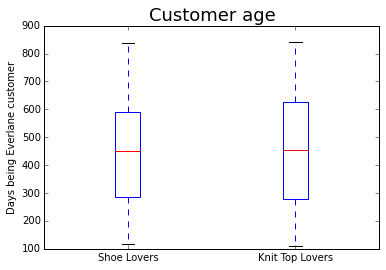

In [17]:
quartiles = [0,.25,.5,.75,1]

## get quartiles
q1 = shoe_lovers_df['age'].quantile(quartiles)
q2 = kt_lovers_df['age'].quantile(quartiles)

## we can represent quartiles as box plots (duh)
q1 = [i for i in q1]
q2 = [i for i in q2]
q = [q1,q2]
plt.boxplot(q)
plt.title('Customer age', fontsize=18) 
plt.ylabel('Days being Everlane customer') # y axis title
plt.xticks([1,2], ['Shoe Lovers','Knit Top Lovers']) # x axis labels

The two groups have a strikingly similar “age” distribution, with **Knit Top Lovers** being ever-so-slightly older. This could inform the email campaign, suggesting that **if there is a loyalty program/bonus involved with the campaign, a “Knit Top Lovers” email campaign with the same program could be equally effective in this regard.**

Obviously “customer age” is just one of many continuous features. We can easily reproduce this for any continuous variable that we can get our hands on. 

# 2. Experimentation
Creating an A/B test to measure effectiveness of the “Shoe Lovers email campaign.” We will assume the campaign creative itself is fixed, and that we have a list of “shoe lovers” to target.

### Goal
We’re going to assume the **campaign goal is to sell a shoe (conversions)**, as opposed to brand/product-awareness or new users, etc.

### Hypothesis
Our hypothesis is that **shoe lovers who receive this promotional email are more likely to buy this shoe than people who did not receive the email**

### Experiment
- Did shoe lovers who were targeted buy the shoe?
- Did shoe lovers who weren’t targeted buy the shoe?

To run this experiment, we can target:
1. Some shoe lovers
2. Some non-shoe lovers

Data providing, we can capture the data as shown in the table below:

In [18]:
## ignore this 
user_id = ['1','2','3']
shoe_lover = [True,False,False]
targeted = [True, False,True]
link_clicked = [True,False,False]
conversion = [False,False,False]
df = pd.DataFrame({'user_id':user_id
                ,'shoe_lover':shoe_lover
                ,'targeted':targeted
                ,'link_clicked':link_clicked
                ,'conversion':conversion
})
order = ['user_id','shoe_lover','targeted','link_clicked','conversion']
df[order]

,user_id,shoe_lover,targeted,link_clicked,conversion
0,1,True,True,True,False
1,2,False,False,False,False
2,3,False,True,False,False


We’ll have two groups, each one having 2 subgroups: 
1. Shoe lovers (shoe_lover == True)
  - Target (targeted == True)
  - Control (targeted == False)
2. Other (shoe_lover == False)
  - Target (targeted == True)
  - Control (targeted == False)


We’re primarily concerned with the **conversion rate** `len(df[df['conversion'] == True])/len(df)` for each group, but can look at **click-through rate** `len(df[df['link_clicked'] == True])/len(df)` as well.


### Evaluation

Our hypothesis states that these rates for `shoe_lovers.target` should be higher than the rate for `shoe_lovers.control`, and same for “other.”

If the lift, or `shoe_lovers.target.rate`/`shoe_lovers.control.rate` is greater than 1, then we can potentially consider it a success. 

To determine how much above 1 the value needs to be, to be considered a success, we can look at the **cost-per conversion** and **RoAS**.
This involves comparing the **media cost** (in this case, cost of sending an email) with the **net revenue** gained when a shoe is purchased.



# 3. Cookie Pairing

In [19]:
## Set up initial dataframe

ip = ['1.1.1','1.1.1','2.2.2','2.2.2','2.2.2','3.3.3']
cookie = ['abc','cbd','abc','def','ghi','jkl']
user = ['123','','123','123','356','']

df = pd.DataFrame({'ip_address':ip,'cookie_id':cookie,'user_id':user})
order = ['ip_address','cookie_id','user_id']
df[order]

,ip_address,cookie_id,user_id
0,1.1.1,abc,123
1,1.1.1,cbd,
2,2.2.2,abc,123
3,2.2.2,def,123
4,2.2.2,ghi,356
5,3.3.3,jkl,


In [20]:
## get the pairs into their own dataframe
cookie_user_match_df = df[['cookie_id','user_id']].drop_duplicates()

## convert this dataframe to a dictionary
match_df = cookie_user_match_df.to_dict(orient='index')

## use a dict comprehension to get it into an easier-to-use format
match_dict = {j['cookie_id']:j['user_id'] for i,j in match_df.items()}

match_dict

{'abc': '123', 'cbd': '', 'def': '123', 'ghi': '356', 'jkl': ''}

## Assumptions
- Empty user_id means we don’t know who that cookie_id belongs to. Two empty user_ids are _not_ the same user.

## 1. Create separate match table for `cookie_id` to `user_id`

## 2. Ignoring the user_id column, join the original dataframe with itself on the `ip_address` column to get combinations

In [21]:
## we don’t want the user_id column anymore
ddf = df[['ip_address','cookie_id']]

## merging on ip_address gets us every combination of ip_address,cookie_id_1,cookie_id_2
ddf = ddf.merge(ddf,on='ip_address',how='left',suffixes=('_1','_2'))

ddf

,ip_address,cookie_id_1,cookie_id_2
0,1.1.1,abc,abc
1,1.1.1,abc,cbd
2,1.1.1,cbd,abc
3,1.1.1,cbd,cbd
4,2.2.2,abc,abc
5,2.2.2,abc,def
6,2.2.2,abc,ghi
7,2.2.2,def,abc
8,2.2.2,def,def
9,2.2.2,def,ghi


This is way too many combinations. We have rows where the pair is the same (index 0, 3, etc), as well as rows where the pairs are just in reverse order (index 5 and 7). We can remove these rows:

In [22]:
## remove rows where both cookie ids are the same
ddf = ddf[ddf['cookie_id_1'] != ddf['cookie_id_2']]

## remove rows where the pair is already in another column but the pair is in reverse order
def create_pair(row):
  ## helper function to identify unique combinations
  ip = row['ip_address']
  c1 = row['cookie_id_1']
  c2 = row['cookie_id_2']
  combo_list = sorted([ip,c1,c2])
  combo_string = ' '.join(combo_list)
  return combo_string

ddf['combination'] = ddf.apply(create_pair, axis=1)
ddf = ddf.drop_duplicates(subset='combination')
ddf = ddf[['ip_address','cookie_id_1','cookie_id_2']]
ddf

/Users/wilburchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ip_address,cookie_id_1,cookie_id_2
1,1.1.1,abc,cbd
5,2.2.2,abc,def
6,2.2.2,abc,ghi
9,2.2.2,def,ghi


Now that we have the right columns and rows, we can start mapping the cookies to their users, then the users to each other, to see if they’re the same person

### 3. Using our match dictionary from earlier, compare cookies and create final column

In [23]:
def is_same_user(c1,c2):
  u1 = match_dict[c1]
  u2 = match_dict[c2]
  ## if one of them is empty, then we can’t reach a conclusion
  if u1 == '' or u2 == '':
    match = 0
  else:
    if u1 == u2:
      match = 1
    else:
      match = 0
  return match

ddf['is_same_user'] = ddf.apply(lambda row: is_same_user(row['cookie_id_1'],row['cookie_id_2']), axis=1)

ddf

,ip_address,cookie_id_1,cookie_id_2,is_same_user
1,1.1.1,abc,cbd,0
5,2.2.2,abc,def,1
6,2.2.2,abc,ghi,0
9,2.2.2,def,ghi,0
